# My Submission: Part Three

The below code is from 

<b>Part One</b>:
https://github.com/elunatik/Coursera_Capstone/blob/master/Python%20Notebook/My%20Submission%20-%20Part%20One.ipynb

and 

<b>Part Two</b>:
https://github.com/elunatik/Coursera_Capstone/blob/master/Python%20Notebook/My%20Submission%20-%20Part%20Two.ipynb

In [1]:
# Importing all necessary libraries from the "Segmenting and Clustering Neighborhoods in New York City" lab
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Importing the Web Scraping libraries
# Install these into your system/environment if not downloaded
import requests
import lxml.html as lh

# The url for the wiki page
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')
tr_elements = doc.xpath('//tr')
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    col.append((name,[]))
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 3, the //tr data is not from our table 
    if len(T)!=3:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content() 
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)

# Removing the '\n' from the last column since this character was in every data cell.
df[col[2][0]] = df[col[2][0]].astype(str).str[:-1]

# Changed the Column Names and removing the 'Not assigned' rows
df.columns = ['PostalCode', 'Borough','Neighborhood']
df = df[df.Borough != 'Not assigned']

# Grouping the dataframe by PostalCode AND Borough then Joining the Neighborhood by a comma
df.set_index(['PostalCode', 'Borough'],inplace=True)
df = df.groupby(level=['PostalCode','Borough'], sort=False).agg( ', '.join)

# Resetting the index back to integers
df.reset_index(inplace=True)

# Reading the csv file, which is in the smae folder as my notebook
geoData = pd.read_csv('Geospatial_Coordinates.csv')

# Changing the index to postal code to easily group/merge the two datframes based on the left('df') dataframe.
df.set_index('PostalCode', inplace = True) # Left Dataframe
geoData.set_index('Postal Code', inplace = True) # Right Dataframe

# I use .merge() based on the index and with a left join. 
# Left since we want to keep all of the rows from our original dataframe.
# Luckily there are coordinates for each Postal Code.
dfComplete = df.merge(geoData, left_index=True, right_index=True, how='left')
dfComplete.reset_index(inplace=True)

print('The shape of the dataframe is: ' + str(dfComplete.shape))
dfComplete.head()

The shape of the dataframe is: (103, 5)


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Not assigned,43.662301,-79.389494


### Part Three: We will now Explore and Cluster the neighborhoods
Using the same libraries and methods used in the week three lab, we will cluster neighborhoods in Toronto.
I Will be using most of the same code used in the lab, and I will note which changes I made in order have the code work for our Toronto data.

Below are the libraties used in out lab 

In [2]:
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In [3]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


Below we will use the same code as the lab, but we will change the New York data into Toronto data.

In [4]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map. On my PC .CircleMarker() does not have the parameter 'parse_html' so I removed it.
# I also changed the dataframe name to dfComplete
for lat, lng, borough, neighborhood in zip(dfComplete['Latitude'], dfComplete['Longitude'], dfComplete['Borough'], dfComplete['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

I will now get the Toronto Data and I will re-use the map code from above since we do not have many data as we did for New York. I will also zoom further in to view the data points which have <b>Toronto</b> in its name

In [5]:
toronto_data = dfComplete[dfComplete['Borough'].str.contains("Toronto")].reset_index(drop=True)
print('The shape of the dataframe is: ' + str(toronto_data.shape))

The shape of the dataframe is: (38, 5)


In [6]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)
map_toronto

Below are my credentials for FourSquare. I ran the code with my credentials, but I saved the file after I removed my credentials

In [7]:
CLIENT_ID = 'UPX3DQWNOVURCU4JGBGCMOQU023OTZJIYE3QWLKF53XUFML4' # your Foursquare ID
CLIENT_SECRET = 'JWPBHGHKGM1CI3WFWDFHOQYVG0WZI2ZSHCM4GT5QZU1YMLA4' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UPX3DQWNOVURCU4JGBGCMOQU023OTZJIYE3QWLKF53XUFML4
CLIENT_SECRET:JWPBHGHKGM1CI3WFWDFHOQYVG0WZI2ZSHCM4GT5QZU1YMLA4


By taking the same steps as our lab, I will first look into the first postal code.

<pre><b>Note</b>: New York had distinct Neighborhoods, but Toronto has distinct Postal Codes.

In [8]:
toronto_data.loc[0, 'PostalCode']

'M5A'

In [9]:
postal_latitude = toronto_data.loc[0, 'Latitude'] # Postal Code latitude value
postal_longitude = toronto_data.loc[0, 'Longitude'] # Postal Code longitude value

postal_name = toronto_data.loc[0, 'PostalCode'] # Postal Code

print('Latitude and longitude values of {} are {}, {}.'.format(postal_name, 
                                                               postal_latitude, 
                                                               postal_longitude))

Latitude and longitude values of M5A are 43.6542599, -79.3606359.


Now, like in the lab, we will get a limit of <b>100</b> venues in a <b>500</b> mile radius.

In [10]:
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    postal_latitude, 
    postal_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=UPX3DQWNOVURCU4JGBGCMOQU023OTZJIYE3QWLKF53XUFML4&client_secret=JWPBHGHKGM1CI3WFWDFHOQYVG0WZI2ZSHCM4GT5QZU1YMLA4&v=20180605&ll=43.6542599,-79.3606359&radius=500&limit=100'

In [11]:
results = requests.get(url).json()

Below are the two functions used in the lab that we will now use for the Toronto data

In [12]:
# functions that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Below are the venues found for the first postal code

In [13]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]


print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

44 venues were returned by Foursquare.


Now we will get the venues for all postal codes that have the name 'Toronto' in it

In [14]:
toronto_venues = getNearbyVenues(names=toronto_data['PostalCode'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

M5A
M5B
M5C
M4E
M5E
M5G
M6G
M5H
M6H
M5J
M6J
M4K
M5K
M6K
M4L
M5L
M4M
M4N
M5N
M4P
M5P
M6P
M4R
M5R
M6R
M4S
M5S
M6S
M4T
M5T
M4V
M5V
M4W
M5W
M4X
M5X
M4Y
M7Y


In [15]:
print(toronto_venues.shape)

(1681, 7)


In [16]:
toronto_venues.groupby('PostalCode').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
PostalCode,,,,,,
M4E,4,4,4,4,4,4
M4K,43,43,43,43,43,43
M4L,20,20,20,20,20,20
M4M,39,39,39,39,39,39
M4N,3,3,3,3,3,3
M4P,8,8,8,8,8,8
M4R,20,20,20,20,20,20
M4S,32,32,32,32,32,32
M4T,2,2,2,2,2,2


In [17]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 235 uniques categories.


We use One Hot Encoding since the data is categorical. This code is also from the lab.

In [18]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add PostalCode column back to dataframe
toronto_onehot['PostalCode'] = toronto_venues['PostalCode'] 

# move PostalCode column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,PostalCode,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,M5A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,M5A,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [19]:
toronto_onehot.shape

(1681, 236)

In [20]:
toronto_grouped = toronto_onehot.groupby('PostalCode').mean().reset_index()

In [21]:
toronto_grouped.shape

(38, 236)

In [22]:
num_top_venues = 5

for code in toronto_grouped['PostalCode']:
    temp = toronto_grouped[toronto_grouped['PostalCode'] == code].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

In a quick skim, we can see that coffee shops and restaurants are frequent.

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [24]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['PostalCode'] = toronto_grouped['PostalCode']

for ind in np.arange(toronto_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,PostalCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,Health Food Store,Coffee Shop,Pub,Neighborhood,Convenience Store,Cosmetics Shop,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
1,M4K,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Bookstore,Yoga Studio,Brewery,Bubble Tea Shop,Restaurant,Caribbean Restaurant
2,M4L,Park,Sandwich Place,Italian Restaurant,Pet Store,Pub,Movie Theater,Burrito Place,Burger Joint,Brewery,Liquor Store
3,M4M,Café,Coffee Shop,Bakery,American Restaurant,Italian Restaurant,Gastropub,Latin American Restaurant,Fish Market,Juice Bar,Clothing Store
4,M4N,Park,Swim School,Bus Line,Yoga Studio,Diner,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


In [25]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('PostalCode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 3, 3, 0, 3, 3, 3, 1, 3])

In [26]:
# add clustering labels
venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(venues_sorted.set_index('PostalCode'), on='PostalCode')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,3,Coffee Shop,Café,Bakery,Park,Mexican Restaurant,Breakfast Spot,Pub,Theater,Historic Site,Electronics Store
1,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,3,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Middle Eastern Restaurant,Japanese Restaurant,Theater,Ramen Restaurant,Restaurant,Diner
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,3,Coffee Shop,Restaurant,Hotel,Café,Breakfast Spot,Bakery,Cosmetics Shop,Gastropub,Clothing Store,Beer Bar
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,3,Health Food Store,Coffee Shop,Pub,Neighborhood,Convenience Store,Cosmetics Shop,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,3,Coffee Shop,Restaurant,Cocktail Bar,Cheese Shop,Steakhouse,Bakery,Italian Restaurant,Seafood Restaurant,Farmers Market,Pub


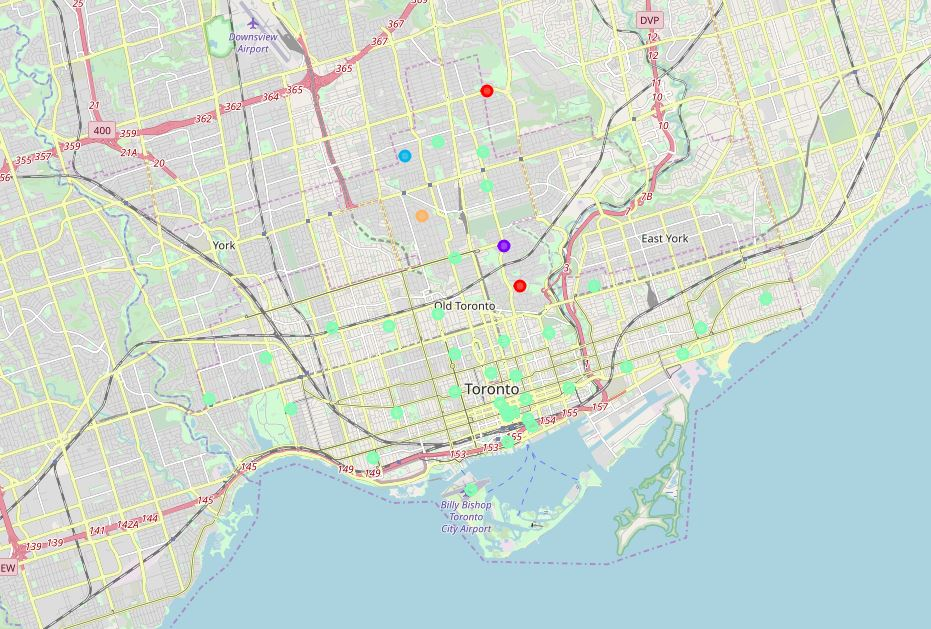

In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['PostalCode'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
#map_clusters
map_clusters

from IPython.display import Image
Image(filename = "map.jpg")

In [28]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Central Toronto,1,Playground,Tennis Court,Comfort Food Restaurant,Comic Shop,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant


In [29]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Central Toronto,2,Garden,Yoga Studio,Diner,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [30]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,3,Coffee Shop,Café,Bakery,Park,Mexican Restaurant,Breakfast Spot,Pub,Theater,Historic Site,Electronics Store
1,Downtown Toronto,3,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Middle Eastern Restaurant,Japanese Restaurant,Theater,Ramen Restaurant,Restaurant,Diner
2,Downtown Toronto,3,Coffee Shop,Restaurant,Hotel,Café,Breakfast Spot,Bakery,Cosmetics Shop,Gastropub,Clothing Store,Beer Bar
3,East Toronto,3,Health Food Store,Coffee Shop,Pub,Neighborhood,Convenience Store,Cosmetics Shop,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
4,Downtown Toronto,3,Coffee Shop,Restaurant,Cocktail Bar,Cheese Shop,Steakhouse,Bakery,Italian Restaurant,Seafood Restaurant,Farmers Market,Pub
5,Downtown Toronto,3,Coffee Shop,Café,Italian Restaurant,Burger Joint,Bar,Spa,Ice Cream Shop,Bubble Tea Shop,Salad Place,Thai Restaurant
6,Downtown Toronto,3,Grocery Store,Café,Park,Baby Store,Restaurant,Convenience Store,Diner,Coffee Shop,Italian Restaurant,Nightclub
7,Downtown Toronto,3,Coffee Shop,Thai Restaurant,Steakhouse,Bar,Café,Hotel,Sushi Restaurant,Asian Restaurant,American Restaurant,Gym
8,West Toronto,3,Bakery,Pharmacy,Discount Store,Supermarket,Gym / Fitness Center,Coffee Shop,Pool,Music Venue,Café,Middle Eastern Restaurant
9,Downtown Toronto,3,Coffee Shop,Hotel,Aquarium,Italian Restaurant,Café,Brewery,Pizza Place,Scenic Lookout,Fried Chicken Joint,Music Venue


In [31]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Central Toronto,4,Mexican Restaurant,Sushi Restaurant,Trail,Jewelry Store,Yoga Studio,Diner,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store


In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
